In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import time

In [2]:
heart = pd.read_csv('heart_train.csv')

In [3]:
def data_preprocessing(df):

    # Diabetic column fix
    df['DiabeticComment'] = df['Diabetic'].apply(lambda row: 'pregnancy' if 'pregnancy' in row
                                                 
                                                         else 'borderline' if 'borderline' in row
                                                 
                                                         else 'no_comment'
                                                )
    
    df['Diabetic'] = df['Diabetic'].apply(lambda row: 'Yes' if 'Yes' in row
                                                 else 'No' if 'No' in row
                                                 else row
                                         )
    
    # Replacing the no into 0, and yes into 1
    df.replace('No', 0, inplace = True)
    df.replace('Yes', 1, inplace = True)
    
    df.Sex.replace('Male', 1, inplace = True)
    df.Sex.replace('Female', 0, inplace = True)
    
    df['AgeCategoryNum'] = df.AgeCategory.apply(lambda row: int(row[0:2]))

    # df['Race']: ignore for now
    
    # GenHealth:
    health = ['Poor', 'Fair', 'Good', 'Very good', 'Excellent']
    health_rank = [0, 1, 2, 3,4]
    health_dict = dict(zip(health, health_rank))
    
    df['GenHealth'] = df['GenHealth'].apply(lambda row: health_dict[row])

In [4]:
data_preprocessing(heart)

In [5]:
n = 1
plt.figure(figsize = (10,30))

yes = heart.query('HeartDisease == 1')
no = heart.query('HeartDisease == 0')

# Normalize
kwargs = dict(alpha=0.5, bins=100, density=True, stacked=True)

for col in heart.columns[2:]:
    
    
    plt.subplot(10, 2, n)
    
    plt.title(col)
    
    # Split with 0, 1
    
    x1 = yes[col]
    x2 = no[col]
    
    
    plt.hist(yes[col], **kwargs, color = 'r', label = 'Yes')
    plt.hist(no[col], **kwargs, color = 'g', label = 'No')
    
    plt.legend()    
    n +=1

# Train the model - ANN

Configure the keras model:

https://www.section.io/engineering-education/build-ann-with-keras/

& Setup the input


In [70]:
import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import roc_curve, auc
from keras.models import Sequential
from keras.layers import Dense
from livelossplot import PlotLossesKeras # For visualize training loss

sc = StandardScaler()
exp_data = []

In [71]:
def auc_rf(y_test, y_pred):
    fpr_rf, tpr_rf, thresholds_rf = roc_curve(y_test, y_pred)
    auc_rf = auc(fpr_rf, tpr_rf)
    
    return auc_rf 


def recombine_norm_and_category(norm, cate):
    norm = pd.DataFrame(norm)
    cate = pd.DataFrame(cate)
    return pd.concat([norm, cate], axis = 1)


# List the interested features:
train_feat = ['BMI', 'Smoking', 'AlcoholDrinking', 'Stroke', 'PhysicalHealth', 'MentalHealth', 'DiffWalking', 'Sex','AgeCategoryNum', 'Diabetic', 'GenHealth', 'SleepTime', 'Asthma', 'KidneyDisease', 'SkinCancer']

# Quickly identify categorical data:
categorical_col = []
norm_col = []
for col in train_feat:
    if len(heart[col].unique().tolist()) <= 10: 
        categorical_col.append(col)
    else:
        norm_col.append(col)

In [72]:
X_category = heart[categorical_col].values
X_norm = heart[norm_col].values
y = heart['HeartDisease'].values

X_category_train, X_category_test, X_norm_train, X_norm_test, y_train, y_test = train_test_split(X_category, X_norm, y, test_size = 0.1, random_state = 1)

X_norm_train = sc.fit_transform(X_norm_train)
X_norm_test = sc.transform(X_norm_test)

X_train = recombine_norm_and_category(X_norm_train, X_category_train)
X_test = recombine_norm_and_category(X_norm_test, X_category_test)


In [73]:
def testing_model1(batch_size, exp_data, epoch = 10):
    layer = 3
    
    # define the keras model
    model = Sequential()
    model.add(Dense(units = 8, input_dim=len(train_feat), activation='relu'))
    model.add(Dense(units = 8, activation='relu'))
    model.add(Dense(units = 1, activation='relu'))

    # compile the keras model
    model.compile(loss='binary_crossentropy', 
                  optimizer='adam', 
                  metrics=['accuracy', 
#                            tf.keras.metrics.Precision(), 
#                            tf.keras.metrics.Recall()
                          ])

    time_start = time.time() 
    
    # fit the keras model on the dataset
    model.fit(X_train, y_train, 
              epochs=epoch, batch_size=batch_size, 
              callbacks=[PlotLossesKeras()])

    time_end = time.time()
    
    y_pred = model.predict(X_test)
    y_pred = y_pred.reshape(len(y_pred))
    
    # evaluate the keras model
    loss, accuracy = model.evaluate(X_test, y_test)
    print('Accuracy: %.2f' % (accuracy*100))
    
    auc = auc_rf(y_test, y_pred)
#     f1 = (2 * prec * recall) / (prec + recall)
    
    exp_data.append([layer, epoch, batch_size, (time_end - time_start), loss, accuracy, auc])

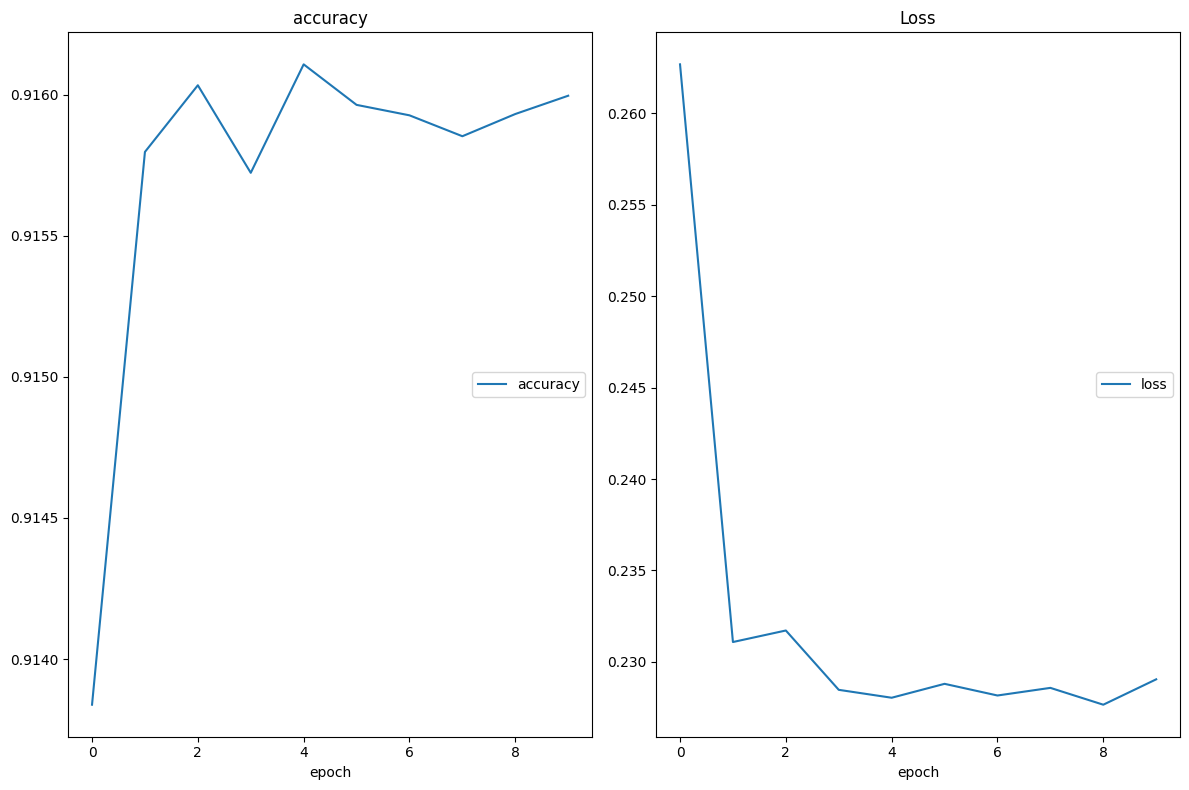

accuracy
	accuracy         	 (min:    0.914, max:    0.916, cur:    0.916)
Loss
	loss             	 (min:    0.228, max:    0.263, cur:    0.229)
750/750 [==============================] - 1s 770us/step - loss: 0.2392 - accuracy: 0.9147
Accuracy: 91.47


In [74]:
batch_size = 10
testing_model1(batch_size, exp_data)

batch_size = 15
testing_model1(batch_size, exp_data)

batch_size = 20
testing_model1(batch_size, exp_data)

In [75]:
def testing_model2(batch_size, exp_data, epoch = 10):
    layer = 4
    
    # define the keras model
    model = Sequential()
    model.add(Dense(units = 8, input_dim=len(train_feat), activation='relu'))
    model.add(Dense(units = 8, activation='relu'))
    model.add(Dense(units = 8, activation='relu'))
    model.add(Dense(units = 1, activation='relu'))

    # compile the keras model
    model.compile(loss='binary_crossentropy', 
                  optimizer='adam', 
                  metrics=['accuracy', 
#                            tf.keras.metrics.Precision(), 
#                            tf.keras.metrics.Recall()
                          ])

    time_start = time.time() 
    
    # fit the keras model on the dataset
    model.fit(X_train, y_train, 
              epochs=epoch, batch_size=batch_size, 
              callbacks=[PlotLossesKeras()])

    time_end = time.time()
    
    y_pred = model.predict(X_test)
    y_pred = y_pred.reshape(len(y_pred))
    
    # evaluate the keras model
    loss, accuracy = model.evaluate(X_test, y_test)
    print('Accuracy: %.2f' % (accuracy*100))
    
    auc = auc_rf(y_test, y_pred)
#     f1 = (2 * prec * recall) / (prec + recall)
    
    exp_data.append([layer, epoch, batch_size, (time_end - time_start), loss, accuracy, auc])

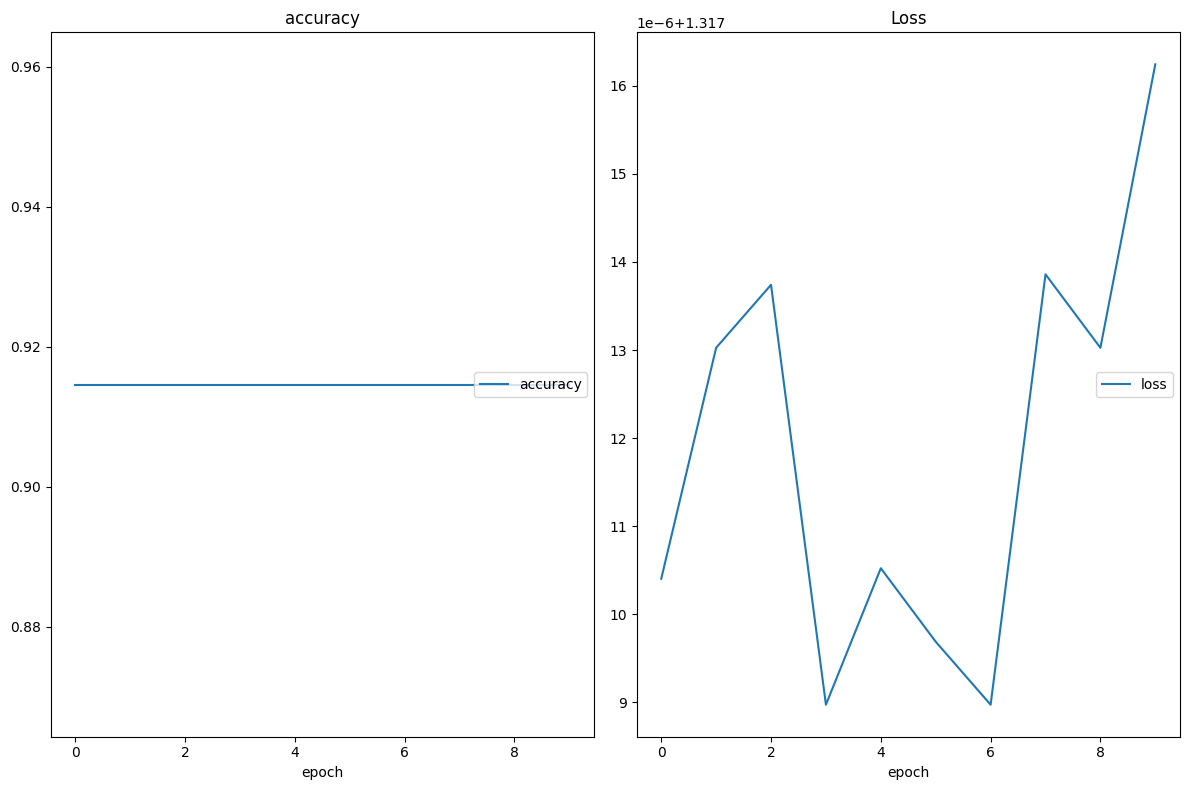

accuracy
	accuracy         	 (min:    0.915, max:    0.915, cur:    0.915)
Loss
	loss             	 (min:    1.317, max:    1.317, cur:    1.317)
750/750 [==============================] - 1s 1ms/step - loss: 1.3370 - accuracy: 0.9133: 0s - loss: 1
Accuracy: 91.33


In [76]:
batch_size = 10
testing_model2(batch_size, exp_data)

batch_size = 15
testing_model2(batch_size, exp_data)

batch_size = 20
testing_model2(batch_size, exp_data)

In [77]:
exp_data_df = pd.DataFrame(exp_data, columns = ['layer','epoch_size', 'batch_size', 'time', 'loss', 'accuracy', 'auc_rf'])
exp_data_df

,layer,epoch_size,batch_size,time,loss,accuracy,auc_rf
0,3,10,10,299.337553,0.235384,0.914530,0.840822
1,3,10,15,187.726245,0.231590,0.914780,0.840376
2,3,10,20,128.022543,0.239189,0.914738,0.841824
3,4,10,10,289.975644,0.261730,0.914155,0.838196
4,4,10,15,194.997836,0.247339,0.914196,0.840176
5,4,10,20,157.935859,1.337023,0.913321,0.500000


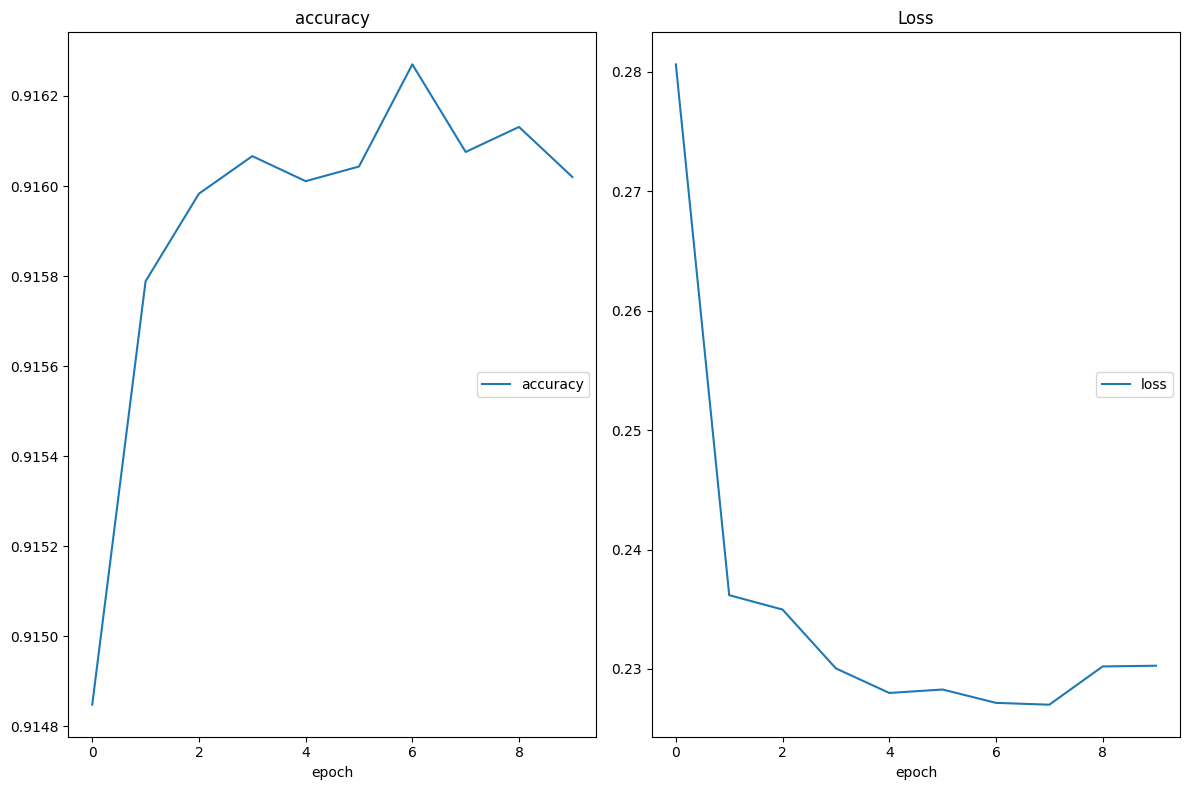

accuracy
	accuracy         	 (min:    0.915, max:    0.916, cur:    0.916)
Loss
	loss             	 (min:    0.227, max:    0.281, cur:    0.230)
750/750 [==============================] - 1s 863us/step - loss: 0.2270 - accuracy: 0.9144
Accuracy: 91.44


In [78]:
batch_size = 30
testing_model2(batch_size, exp_data)

batch_size = 40
testing_model2(batch_size, exp_data)

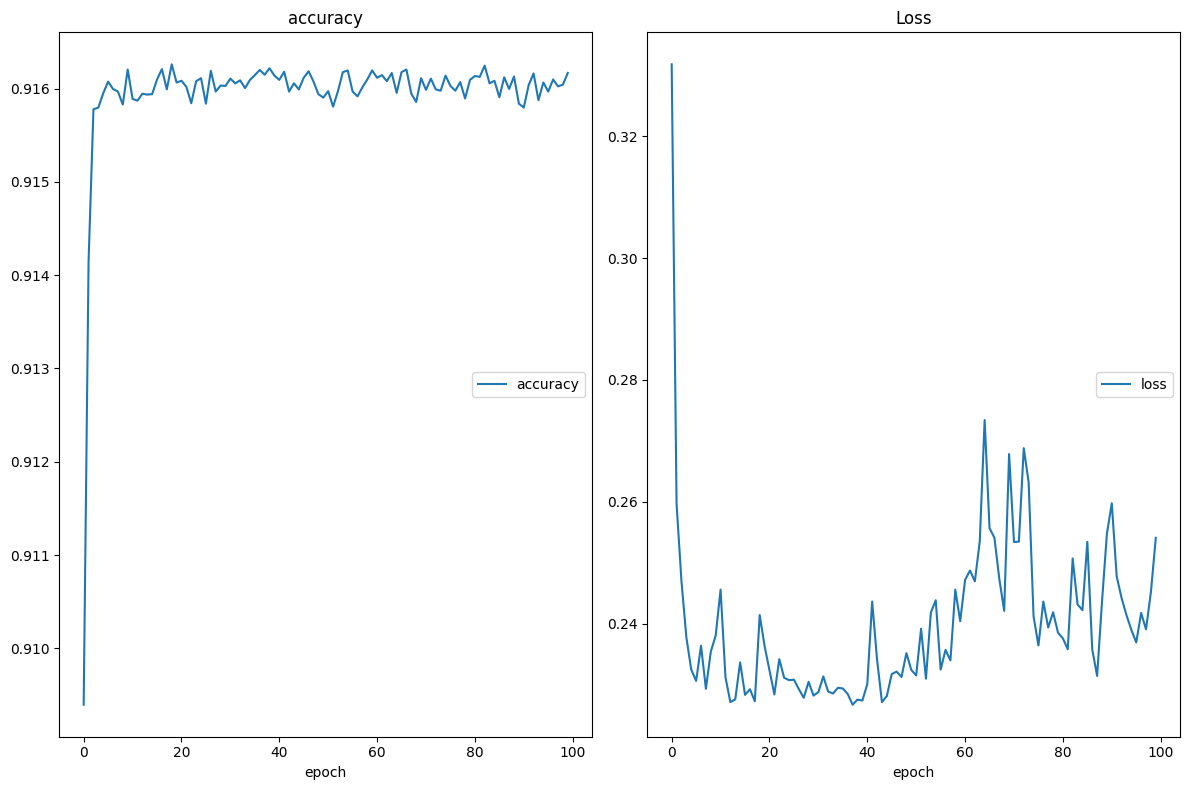

accuracy
	accuracy         	 (min:    0.909, max:    0.916, cur:    0.916)
Loss
	loss             	 (min:    0.227, max:    0.332, cur:    0.254)
750/750 [==============================] - 1s 761us/step - loss: 0.2544 - accuracy: 0.9141
Accuracy: 91.41


In [79]:
batch_size = 40
testing_model2(batch_size, exp_data, epoch = 25)

batch_size = 40
testing_model2(batch_size, exp_data, epoch = 50)

batch_size = 40
testing_model2(batch_size, exp_data, epoch = 100)

In [81]:
def testing_model3(batch_size, exp_data, epoch = 10): # Use sigmoid
    layer = 4
    
    # define the keras model
    model = Sequential()
    model.add(Dense(units = 8, input_dim=len(train_feat), activation='relu'))
    model.add(Dense(units = 8, activation='relu'))
    model.add(Dense(units = 8, activation='relu'))
    model.add(Dense(units = 1, activation='sigmoid'))

    # compile the keras model
    model.compile(loss='binary_crossentropy', 
                  optimizer='adam', 
                  metrics=['accuracy', 
#                            tf.keras.metrics.Precision(), 
#                            tf.keras.metrics.Recall()
                          ])

    time_start = time.time() 
    
    # fit the keras model on the dataset
    model.fit(X_train, y_train, 
              epochs=epoch, batch_size=batch_size, 
              callbacks=[PlotLossesKeras()])

    time_end = time.time()
    
    y_pred = model.predict(X_test)
    y_pred = y_pred.reshape(len(y_pred))
    
    # evaluate the keras model
    loss, accuracy = model.evaluate(X_test, y_test)
    print('Accuracy: %.2f' % (accuracy*100))
    
    auc = auc_rf(y_test, y_pred)
#     f1 = (2 * prec * recall) / (prec + recall)
    
    exp_data.append([layer, epoch, batch_size, (time_end - time_start), loss, accuracy, auc])

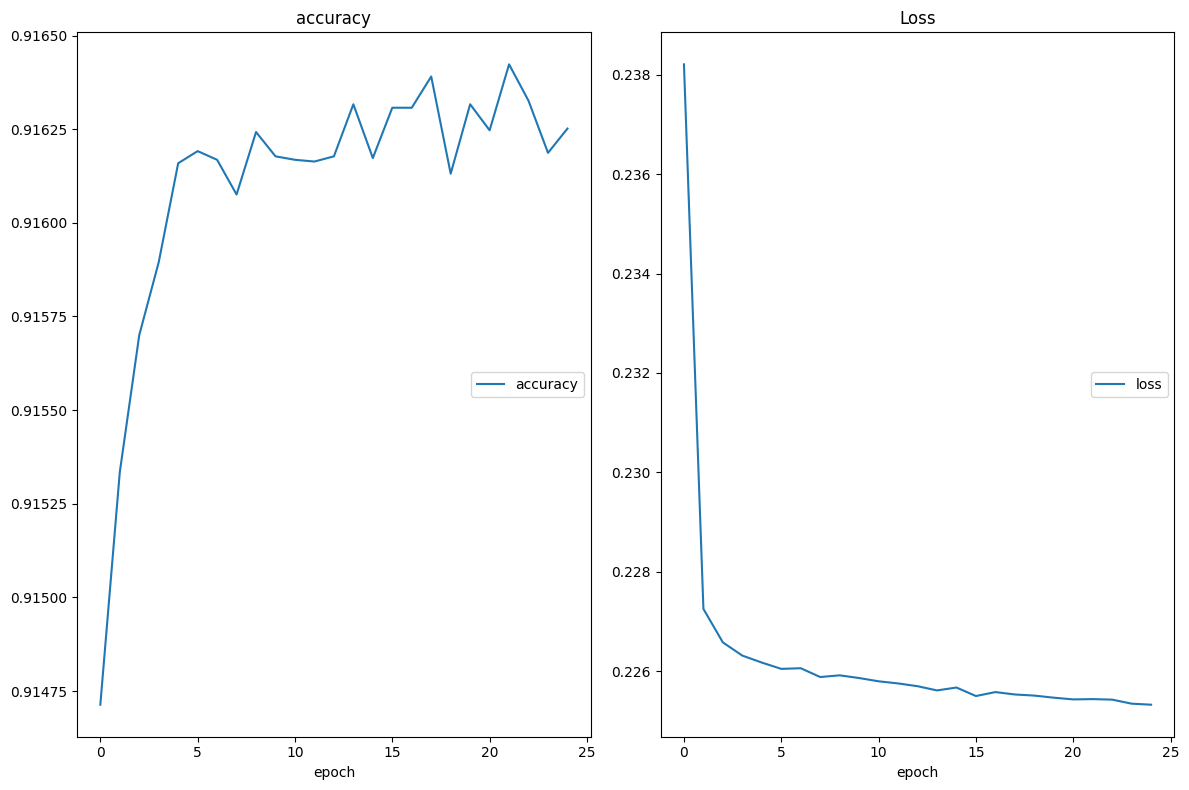

accuracy
	accuracy         	 (min:    0.915, max:    0.916, cur:    0.916)
Loss
	loss             	 (min:    0.225, max:    0.238, cur:    0.225)
750/750 [==============================] - 1s 1ms/step - loss: 0.2265 - accuracy: 0.9148
Accuracy: 91.48


In [85]:
batch_size = 40
testing_model3(batch_size, exp_data, epoch = 25)

In [92]:
def testing_model4(batch_size, exp_data, epoch = 10): # Thicker and fater
    layer = 8
    
    # define the keras model
    model = Sequential()
    model.add(Dense(units = 15, input_dim=len(train_feat), activation='relu'))
    model.add(Dense(units = 10, activation='relu'))
    model.add(Dense(units = 8, activation='relu'))
    model.add(Dense(units = 8, activation='relu'))
    model.add(Dense(units = 8, activation='relu'))
    model.add(Dense(units = 8, activation='relu'))
    model.add(Dense(units = 8, activation='relu'))
    model.add(Dense(units = 1, activation='sigmoid'))

    # compile the keras model
    model.compile(loss='binary_crossentropy', 
                  optimizer='adam', 
                  metrics=['accuracy', 
#                            tf.keras.metrics.Precision(), 
#                            tf.keras.metrics.Recall()
                          ])

    time_start = time.time() 
    
    # fit the keras model on the dataset
    model.fit(X_train, y_train, 
              epochs=epoch, batch_size=batch_size, 
              callbacks=[PlotLossesKeras()])

    time_end = time.time()
    
    y_pred = model.predict(X_test)
    y_pred = y_pred.reshape(len(y_pred))
    
    # evaluate the keras model
    loss, accuracy = model.evaluate(X_test, y_test)
    print('Accuracy: %.2f' % (accuracy*100))
    
    auc = auc_rf(y_test, y_pred)
#     f1 = (2 * prec * recall) / (prec + recall)
    
    exp_data.append([layer, epoch, batch_size, (time_end - time_start), loss, accuracy, auc])
    
def testing_model5(batch_size, exp_data, epoch = 10): # Thicker and fater
    layer = 8
    
    # define the keras model
    model = Sequential()
    model.add(Dense(units = 15, input_dim=len(train_feat), activation='relu'))
    model.add(Dense(units = 15, activation='relu'))
    model.add(Dense(units = 15, activation='relu'))
    model.add(Dense(units = 15, activation='relu'))
    model.add(Dense(units = 15, activation='relu'))
    model.add(Dense(units = 15, activation='relu'))
    model.add(Dense(units = 15, activation='relu'))
    model.add(Dense(units = 1, activation='sigmoid'))

    # compile the keras model
    model.compile(loss='binary_crossentropy', 
                  optimizer='adam', 
                  metrics=['accuracy', 
#                            tf.keras.metrics.Precision(), 
#                            tf.keras.metrics.Recall()
                          ])

    time_start = time.time() 
    
    # fit the keras model on the dataset
    model.fit(X_train, y_train, 
              epochs=epoch, batch_size=batch_size, 
              callbacks=[PlotLossesKeras()])

    time_end = time.time()
    
    y_pred = model.predict(X_test)
    y_pred = y_pred.reshape(len(y_pred))
    
    # evaluate the keras model
    loss, accuracy = model.evaluate(X_test, y_test)
    print('Accuracy: %.2f' % (accuracy*100))
    
    auc = auc_rf(y_test, y_pred)
#     f1 = (2 * prec * recall) / (prec + recall)
    
    exp_data.append([layer, epoch, batch_size, (time_end - time_start), loss, accuracy, auc])

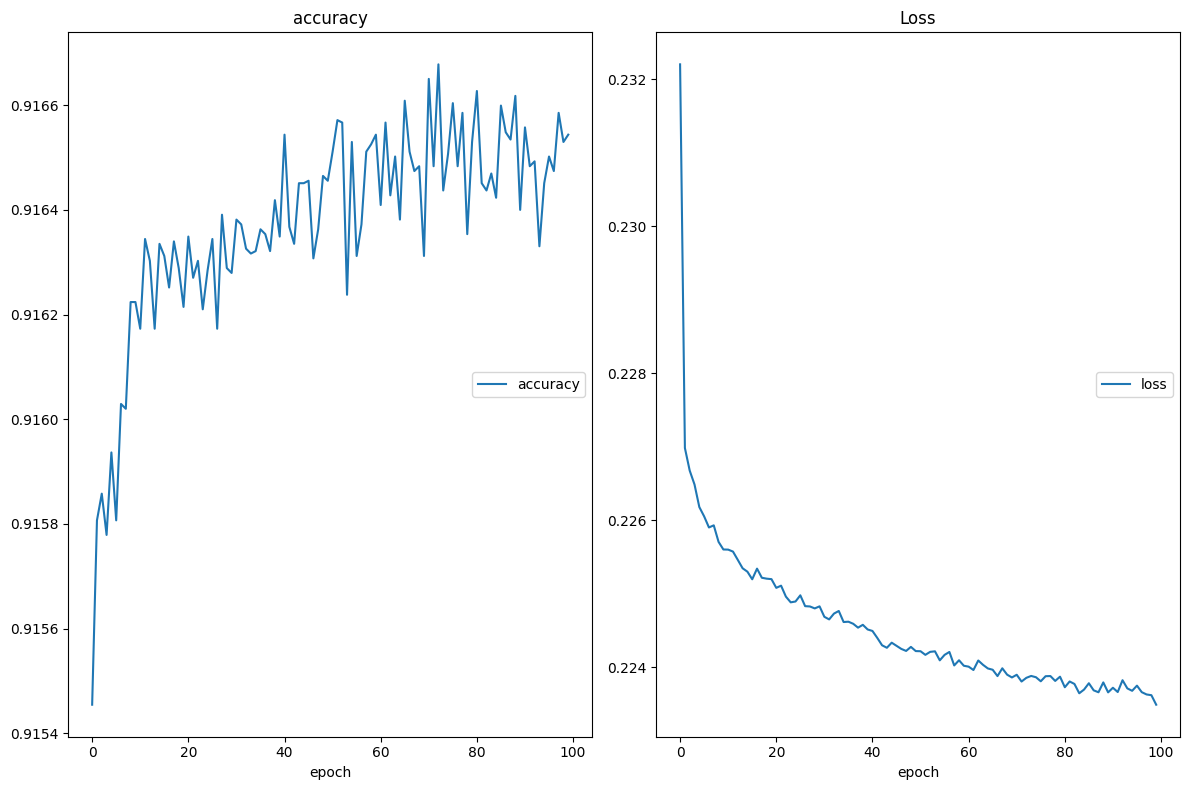

accuracy
	accuracy         	 (min:    0.915, max:    0.917, cur:    0.917)
Loss
	loss             	 (min:    0.223, max:    0.232, cur:    0.223)
750/750 [==============================] - 1s 830us/step - loss: 0.2275 - accuracy: 0.9147
Accuracy: 91.47


In [93]:
batch_size = 40
testing_model5(batch_size, exp_data, epoch = 100)

In [94]:
exp_data_df = pd.DataFrame(exp_data, columns = ['layer','epoch_size', 'batch_size', 'time', 'loss', 'accuracy', 'auc_rf'])
exp_data_df

,layer,epoch_size,batch_size,time,loss,accuracy,auc_rf
0,3,10,10,299.337553,0.235384,0.914530,0.840822
1,3,10,15,187.726245,0.231590,0.914780,0.840376
2,3,10,20,128.022543,0.239189,0.914738,0.841824
3,4,10,10,289.975644,0.261730,0.914155,0.838196
4,4,10,15,194.997836,0.247339,0.914196,0.840176
5,4,10,20,157.935859,1.337023,0.913321,0.500000
6,4,10,30,105.981672,0.227201,0.914697,0.843269
7,4,10,40,72.433481,0.227037,0.914447,0.845306
8,4,25,40,191.871462,0.231099,0.914697,0.843249
9,4,50,40,374.242184,0.242442,0.915072,0.842423


## Conclusion by far:
The increase of epoch and layers doesn't really help by far. The batch size helps a little bit.

# Analysis (Playing)

In [267]:
y_pred = model.predict(X_test)
y_pred = y_pred.reshape(len(y_pred))
fpr_rf, tpr_rf, thresholds_rf = roc_curve(y_test, y_pred)
auc_rf = auc(fpr_rf, tpr_rf)
sum((y_test - y_pred)**2) / len(y_test)

result_comparison = pd.DataFrame(list(zip(y_test, y_pred)), columns=['Actual', 'Predicted'])
result_comparison.query('Actual == 1')

,Actual,Predicted
12,1,0.461399
26,1,0.133048
33,1,0.186850
34,1,0.169545
35,1,0.282824
...,...,...
23877,1,0.388640
23929,1,0.376012
23947,1,0.152014
23972,1,0.049539


Text(0.5, 0, 'True Positive Rate')

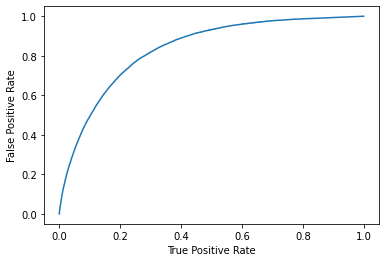

In [209]:
fpr_rf, tpr_rf, thresholds_rf = roc_curve(y_test, y_pred)
auc_rf = auc(fpr_rf, tpr_rf)

plt.plot(fpr_rf, tpr_rf, label = 'modelA')
plt.ylabel('False Positive Rate')
plt.xlabel('True Positive Rate')

In [309]:
scores = model.evaluate(X_test, y_test,verbose = 1)

6746/6746 [==============================] - 7s 1ms/step - loss: 0.2555 - accuracy: 0.9157


In [ ]:
y_pred = model.predict(X_test)
# y_pred = y_pred.reshape(len(y_pred))
f1_m(y_test, y_pred)